# Malaria Classification - Image Classification

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## Preparing the data

In [2]:
dataset, dataset_set = tfds.load('malaria', split=['train'], as_supervised=True, shuffle_files=True, with_info=True)

In [3]:
for data in dataset[0].take(4):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [4]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1

In [5]:
DATASET_SIZE = len(dataset[0])

train_dataset = dataset[0].take(int(TRAIN_RATIO*DATASET_SIZE))

val_dataset = dataset[0].skip(int(TRAIN_RATIO*DATASET_SIZE)) # skips upto 80%
val_dataset = val_dataset.take(int(VAL_RATIO*DATASET_SIZE)) # then takes the 10% of the remaining 20% as validation dataset

test_dataset = dataset[0].skip(int((TRAIN_RATIO+VAL_RATIO)*DATASET_SIZE)) # skips upto 90%
test_dataset = test_dataset.take(int(TEST_RATIO*DATASET_SIZE)) # then takes the 10% as test data

In [6]:
print(len(train_dataset))
print(len(val_dataset))
print(len(val_dataset))

22046
2755
2755


In [7]:
print(list(train_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)]


## Visualising the Dataset

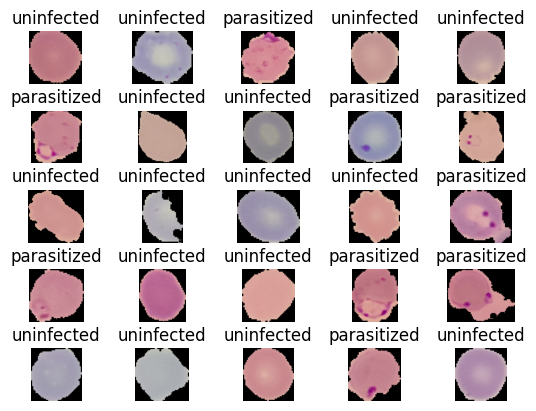

In [8]:
fig = plt.figure()

for i, (image, label) in enumerate(train_dataset.take(25)):
  plt.subplot(5,5, i+1)
  plt.imshow(image)
  plt.title(dataset_set.features['label'].int2str(label))
  plt.axis('off')

# Adjust the space between the plots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

## Data Preprocessing

Normalisation
$$X = \frac{X - X(min)}{X(max) - X(min)}$$

i.e

$$
  X = \frac{X - 0}{255-0}\\
  X = \frac{X}{255}
$$



In [9]:
IMAGE_SIZE = 224

def resizing_rescaling(image, label):
  return tf.image.resize(image, (IMAGE_SIZE,IMAGE_SIZE))/255, label

In [10]:
train_dataset = train_dataset.map(resizing_rescaling)

In [11]:
val_dataset = val_dataset.map(resizing_rescaling)

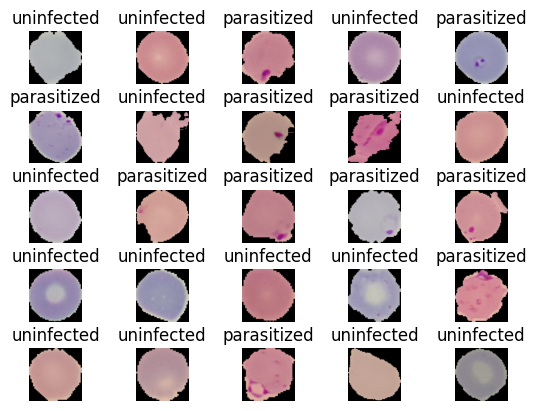

In [12]:
fig = plt.figure()

for i, (image, label) in enumerate(train_dataset.take(25)):
  plt.subplot(5,5, i+1)
  plt.imshow(image)
  plt.title(dataset_set.features['label'].int2str(label))
  plt.axis('off')

# Adjust the space between the plots
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [13]:
BATCH_SIZE = 32

test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Model Building

In [14]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [18]:
# Partial Implementation of LeNet CNN

cnn = tf.keras.Sequential([
     InputLayer(input_shape = (IMAGE_SIZE, IMAGE_SIZE,3), batch_size=32),
     Conv2D(filters=6, kernel_size= 5, activation="relu"),
     MaxPooling2D(pool_size=(2, 2), strides=2),
     Conv2D(filters=16, kernel_size= 5, activation="relu"),
     MaxPooling2D(pool_size=(2, 2), strides=2),
     Flatten(),
     Dense(1000, activation="relu"),
     Dense(100, activation="relu"),
     Dense(1, activation="relu"),
])

print(cnn.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (32, 220, 220, 6)         456       
                                                                 
 max_pooling2d_2 (MaxPoolin  (32, 110, 110, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (32, 106, 106, 16)        2416      
                                                                 
 max_pooling2d_3 (MaxPoolin  (32, 53, 53, 16)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (32, 44944)               0         
                                                                 
 dense_3 (Dense)             (32, 1000)               

In [19]:
cnn.compile(optimizer=Adam(learning_rate=0.1), loss=BinaryCrossentropy(), )

In [20]:
# history = cnn.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1)
history = cnn.fit(train_dataset, epochs=100, verbose=1)

Epoch 1/100
689/689 [==============================] - 36s 45ms/step - loss: 7.6162
Epoch 2/100
689/689 [==============================] - 34s 49ms/step - loss: 7.6232
Epoch 3/100
689/689 [==============================] - 32s 46ms/step - loss: 7.6225
Epoch 4/100
689/689 [==============================] - 31s 45ms/step - loss: 7.6246
Epoch 5/100
689/689 [==============================] - 35s 51ms/step - loss: 7.6246
Epoch 6/100
689/689 [==============================] - 33s 48ms/step - loss: 7.6239
Epoch 7/100
689/689 [==============================] - 32s 47ms/step - loss: 7.6225
Epoch 8/100
689/689 [==============================] - 33s 47ms/step - loss: 7.6253
Epoch 9/100
220/689 [========>.....................] - ETA: 21s - loss: 7.5986

KeyboardInterrupt: ignored

In [ ]:
train_dataset

In [ ]:
val_dataset

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LeNet Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()